# Ikeda $B_e$ assumtion.
Using analytical linear decay solution to calculate the $B_e$

In [1]:
from rolldecayestimators import equations

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 461 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.dpi       : 100        ## figure dots per inch')


# Purpose
The quadratic or cubic model can be expressed using the linearized equivalent damping ($B_e$) according to <cite data-cite="7505983/EYEMHSYH">.:

In [2]:
equations.B_e_equation

Eq(B_e, B_1 + 8*B_2*omega0*phi_a/(3*pi))

In [3]:
equations.B_e_equation_cubic

Eq(B_e, B_1 + 8*B_2*omega0*phi_a/(3*pi) + 0.75*B_3*omega0**2*phi_a**2)

But I have some doubt about the validity of this, which will be investigated in this notebook.

# Methodology
A quadratic and cubic model from Simplified Ikeda will be used to calculate $B_e$. $B_e$ will also be obtained from Roll-decay simulations with these models, will the value be the same?

# WIP - improvements
(WORK IN PROGRESS)
Use this section only if the notebook is not final.

Notable TODOs:
* todo 1
* todo 2
* todo 3

## Results
Describe and comment the most important results.

# Suggested next steps
State suggested next steps, based on results obtained in this notebook.

# Setup

In [4]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables


In [51]:
from rolldecayestimators.simplified_ikeda_class import SimplifiedIkeda
import rolldecayestimators
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares

In [6]:
zeta_lambda = lambdify(sp.solve(equations.extinction_equation,symbols.zeta)[0])

def calculate_B_n(X_amplitudes):
    B_ns=[None,]
    for i in range(len(X_amplitudes)-1):
        
        row1 = X_amplitudes.iloc[i]
        row2 = X_amplitudes.iloc[i+1]
        t_ = row2.name - row1.name
        B_n = zeta_lambda(omega0=row1['omega0'],phi_0=row1['phi_a'], phi_a=row2['phi_a'],
                t=t_)
        B_ns.append(B_n)
        
    return B_ns

## Quadratic

In [6]:
Math(vlatex(equations.roll_decay_equation_himeno_quadratic_b))

<IPython.core.display.Math object>

In [7]:
eq_acceleration_quadratic = sp.Eq(symbols.phi_dot_dot,
                        sp.solve(equations.roll_decay_equation_himeno_quadratic_b,symbols.phi_dot_dot)[0])

accelaration_quadratic_lambda = lambdify(sp.solve(equations.roll_decay_equation_himeno_quadratic_b,symbols.phi_dot_dot)[0])

Math(vlatex(eq_acceleration_quadratic))

<IPython.core.display.Math object>

In [8]:
class RollDecayLinear():
    
    def __init__(self,A_44, B_1, C_1):
        self.parameters = {
            'A_44':A_44,
            'B_1':B_1,
            'C_1':C_1,
        }
            
    def time_step(self,t,states):
        
        phi = states[0]
        phi1d = states[1]
        phi2d = accelaration_linear_lambda(**self.parameters, phi=phi, phi1d=phi1d)
        
        d_states_dt = np.array([phi1d, phi2d])
        return d_states_dt
    
    def simulate(self,t,phi0=np.deg2rad(10),phi1d0=0):
        
        initial_state = [phi0,phi1d0]
        
        t_span = [t[0], t[-1]]
        
        result = solve_ivp(fun=simulation.time_step, t_span=t_span,  y0=initial_state, t_eval=t)
        assert result.success
        df_result = pd.DataFrame(index=result.t, data=result.y.T, columns = ['phi','phi1d'])
        return df_result
    
class RollDecayQuadratic(RollDecayLinear):
    
    def __init__(self,A_44, B_1, B_2, C_1):
        self.parameters = {
            'A_44':A_44,
            'B_1':B_1,
            'B_2':B_2,
            'C_1':C_1,
        }
            
    def time_step(self,t,states):
        
        phi = states[0]
        phi1d = states[1]
        phi2d = accelaration_quadratic_lambda(**self.parameters, phi=phi, phi1d=phi1d)
        
        d_states_dt = np.array([phi1d, phi2d])
        return d_states_dt

In [30]:
N=100000
A_44 = 2.2
B_1 = 0.10
C_1 = 0.5

simulations = {
}

N= 5
B_2s = np.linspace(0,2,N)
for B_2 in B_2s:
    simulations[B_2]=RollDecayQuadratic(A_44=A_44, B_1=B_1, B_2=B_2, C_1=C_1)

In [31]:
equations.C_equation_linear

Eq(C, GM*g*m)

In [32]:
A_44_eq = sp.Eq(symbols.A_44, equations.A44)
A_44_eq

Eq(A_44, GM*g*m/omega0**2)

In [33]:
eqs = [
    A_44_eq,
    equations.C_equation_linear,

]
omega0_eq = sp.Eq(symbols.omega0,sp.solve(eqs, symbols.omega0, symbols.GM)[1][0])
omega0_eq

Eq(omega0, sqrt(C/A_44))

In [43]:
t_span = [t[0], t[-1]]

t = np.arange(0,200,0.01)
phi0=np.deg2rad(10)
phi1d0 = 0
initial_state = [phi0,phi1d0]


results = {}
X_amplitudes = {}
for name,simulation in simulations.items():
    
    df_result = simulation.simulate(t=t, phi0=phi0, phi1d0=phi1d0)
    
    results[name]=df_result
    X_amplitudes[name]=rolldecayestimators.measure.calculate_amplitudes_and_damping(X=df_result)

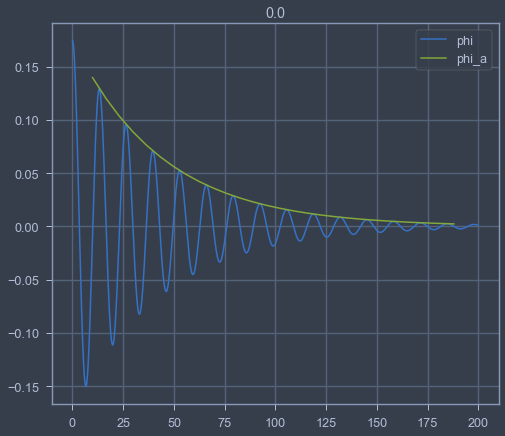

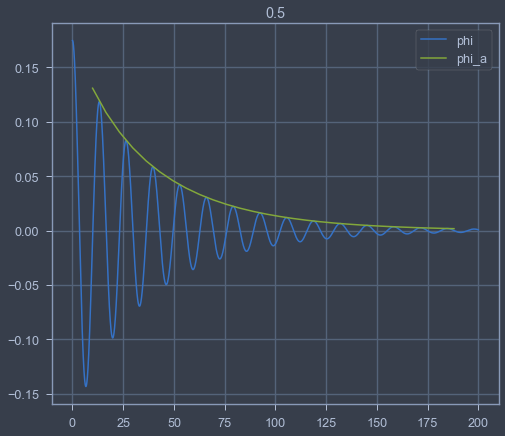

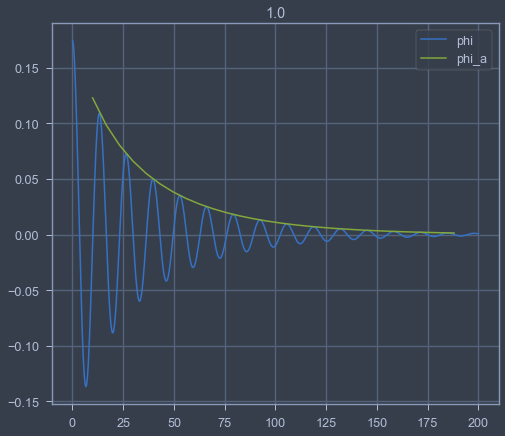

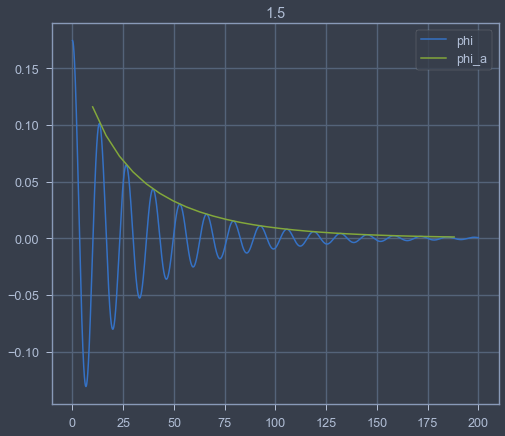

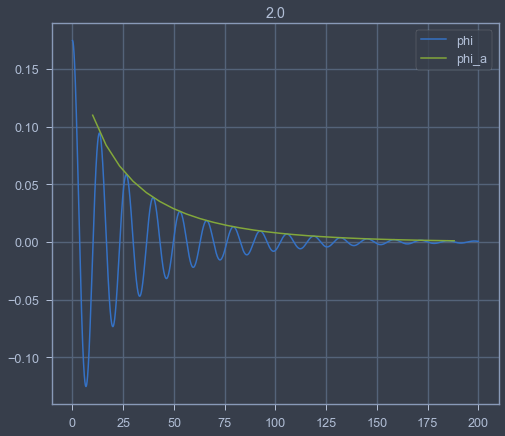

In [44]:
for name in results.keys():
    fig,ax=plt.subplots()
    df_result = results[name]
    amplitudes = X_amplitudes[name]
    df_result.plot(y='phi',ax=ax)
    amplitudes.plot(y='phi_a', ax=ax)
    ax.grid(True)
    ax.set_title(name)

## $B_e$ from anayltica solution

In [45]:
equations.analytical_solution

Eq(phi(t), ((zeta*phi_0(t)/sqrt(1 - zeta**2) + Derivative(phi_0(t), t)/(omega0*sqrt(1 - zeta**2)))*sin(omega0*t*sqrt(1 - zeta**2)) + phi_0(t)*cos(omega0*t*sqrt(1 - zeta**2)))*exp(-omega0*t*zeta))

In [46]:
analytical_lambda = lambdify(sp.solve(equations.analytical_solution,symbols.phi)[0])

In [47]:
equations.extinction_equation

Eq(phi_a, phi_0(t)*exp(-omega0*t*zeta))

In [48]:
sp.Eq(symbols.zeta,sp.solve(equations.extinction_equation,symbols.zeta)[0])

Eq(zeta, log(phi_0(t)/phi_a)/(omega0*t))

In [69]:
def simulate(zeta,X,omega0):
    t = X.index
    initial_states = X.iloc[0]
    phi_0 = initial_states['phi']
    phi_01d= initial_states['phi1d']
    phi_pred = analytical_lambda(omega0=omega0, phi_0=phi_0, phi_01d=phi1d0, t=t, zeta=zeta)
    return phi_pred

def residuals(zeta,X,omega0):
    
    phi_pred = simulate(zeta=zeta, X=X, omega0=omega0)
    residual = phi_pred - X['phi']
    return residual

In [77]:
def linear_equivalent(X,omega0):
    kwargs={
        'X':X,
        'omega0':omega0,
    }
    initial_guess = [B_1]
    result = least_squares(fun=residuals, x0=initial_guess, kwargs=kwargs, method='lm')
    assert result.success is True
    B_e = result.x[0]
    return B_e

In [79]:
X = results[0]
omega0 = np.sqrt(C_1/A_44)

B_e = linear_equivalent(X=X, omega0=omega0)
phi_pred = simulate(zeta=B_e, X=X, omega0=omega0)
phi_error = X['phi'] - phi_pred
r2_score(y_true=X['phi'], y_pred=phi_pred)

0.9999830624230869

In [81]:
df_B_e = pd.DataFrame()
df_B_e.index.name='B_2'

for B_2, X in results.items():
    B_e = linear_equivalent(X=X, omega0=omega0)
    df_B_e.loc[B_2,'B_e'] = B_e
    phi_pred = simulate(zeta=B_e, X=X, omega0=omega0)
    df_B_e.loc[B_2,'R2'] = r2_score(y_true=X['phi'], y_pred=phi_pred)

<AxesSubplot:xlabel='B_2'>

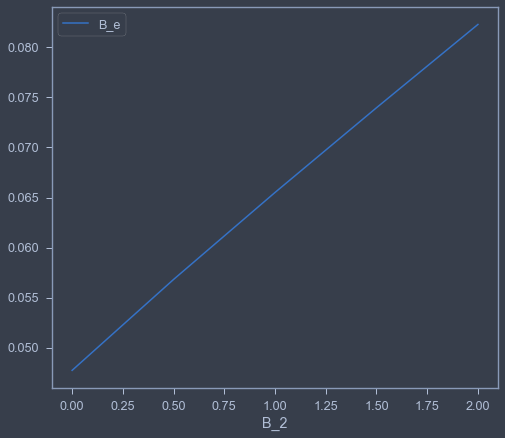

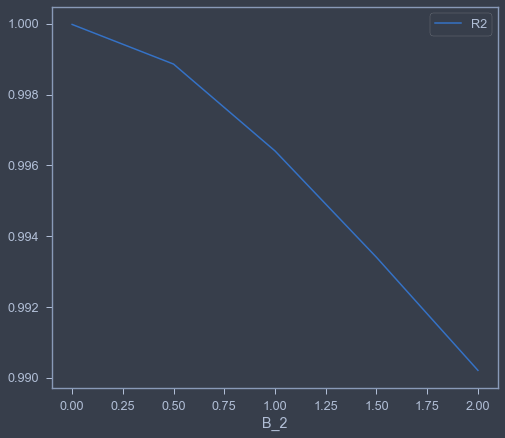

In [85]:
fig,ax=plt.subplots()
df_B_e.plot(y='B_e',ax=ax)

fig,ax=plt.subplots()
df_B_e.plot(y='R2',ax=ax)

In [23]:
for name in results.keys():
    amplitudes = X_amplitudes[name]
    amplitudes['B_n2'] = calculate_B_n(amplitudes)
    
    omega0=amplitudes['omega0']
    phi_a=amplitudes['phi_a']
    amplitudes['B_e'] = B_1 + B_2*8/(3*np.pi)*omega0*phi_a
    
    amplitudes['B_1/2omega0'] = B_1/(2*omega0*A_44)
    amplitudes['B_e/2omega0'] = amplitudes['B_e']/(2*omega0*A_44)
    

<a id='zeta-B'></a>

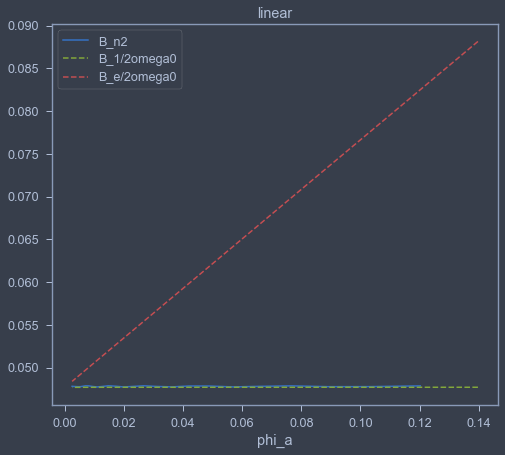

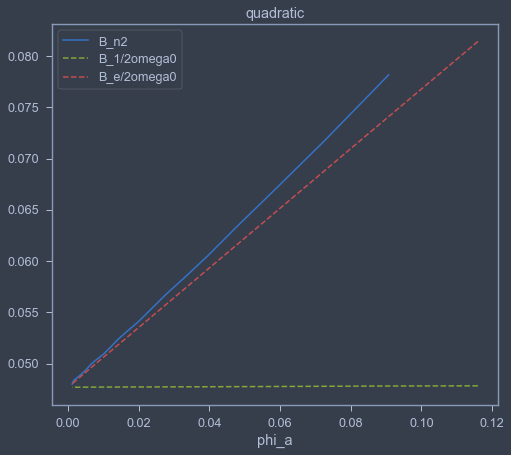

In [24]:
for name in results.keys():
    amplitudes = X_amplitudes[name]
    fig,ax=plt.subplots()
    amplitudes.plot(x='phi_a', y='B_n2', style='-', ax=ax)
    amplitudes.plot(x='phi_a', y='B_1/2omega0', style='--', ax=ax)
    amplitudes.plot(x='phi_a', y='B_e/2omega0', style='--',ax=ax)
    
    y_lim = ax.get_xlim()
    #ax.set_ylim(0,y_lim[1])
    ax.set_title(name)

In [25]:
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

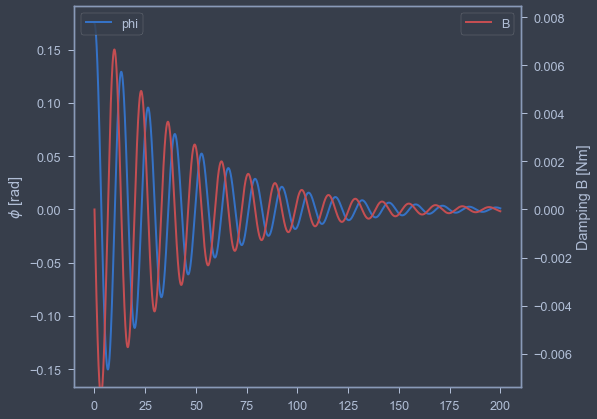

In [26]:
from scipy.integrate import cumtrapz

df_results = results['linear'].copy()
phi = df_results['phi']
phi1d = df_results['phi1d']

df_results['B'] = phi1d*B_1

fig,ax=plt.subplots()
df_results.plot(y='phi', ax=ax, lw=2, alpha=1)
ax.legend(loc='upper left')
ax.set_ylabel('$\phi$ [rad]')

ax_damping = ax.twinx()
df_results.plot(y='B', style='r-', lw=2, ax=ax_damping)
ax_damping.set_ylabel('Damping B [Nm]')

align_yaxis(ax, 0, ax_damping, 0)

In [27]:
df_results['E_kin'] = 1/2*A_44*phi1d**2
E_loss = cumtrapz(df_results['B'],x=phi)
E_loss = np.concatenate([[0],E_loss])
df_results['E_loss'] = E_loss
df_results['E_pot'] = C_1*phi**2/2
df_results['E_sys'] = df_results['E_kin'] + df_results['E_pot']
df_results['E_tot'] = df_results['E_loss'] + df_results['E_sys']

<a id='energy'></a>

Text(0, 0.5, 'Energy [kNm]')

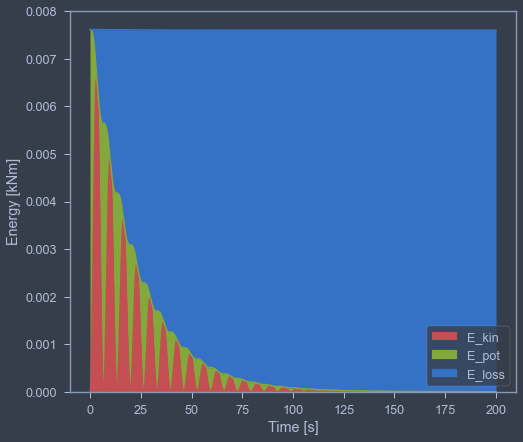

In [28]:
fig,ax=plt.subplots()
df_results.plot.area(y = ['E_kin','E_pot','E_loss'], color=['r','g','b'], ax=ax)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Energy [kNm]')

In [29]:
E_loss2 = cumtrapz(phi1d,x=phi)
E_loss2 = np.concatenate([[0],E_loss2])
B_es = df_results['E_loss']/E_loss2


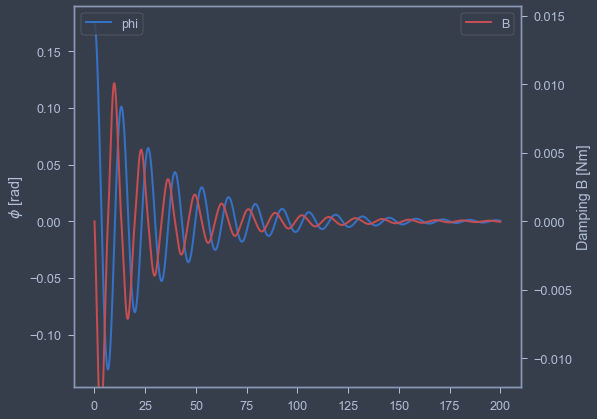

In [30]:
from scipy.integrate import cumtrapz

df_results = results['quadratic'].copy()
phi = df_results['phi']
phi1d = df_results['phi1d']

df_results['B'] = (B_1 + B_2*np.abs(phi1d))*phi1d 

fig,ax=plt.subplots()
df_results.plot(y='phi', ax=ax, lw=2, alpha=1)
ax.legend(loc='upper left')
ax.set_ylabel('$\phi$ [rad]')

ax_damping = ax.twinx()
df_results.plot(y='B', style='r-', lw=2, ax=ax_damping)
ax_damping.set_ylabel('Damping B [Nm]')

align_yaxis(ax, 0, ax_damping, 0)

In [31]:
df_results['E_kin'] = 1/2*A_44*phi1d**2
E_loss = cumtrapz(df_results['B'],x=phi)
E_loss = np.concatenate([[0],E_loss])
df_results['E_loss'] = E_loss
df_results['E_pot'] = C_1*phi**2/2
df_results['E_sys'] = df_results['E_kin'] + df_results['E_pot']
df_results['E_tot'] = df_results['E_loss'] + df_results['E_sys']

In [32]:
E_loss2 = cumtrapz(phi1d,x=phi)
E_loss2 = np.concatenate([[1],E_loss2])

df_results['B_e'] = df_results['E_loss']/E_loss2

<AxesSubplot:>

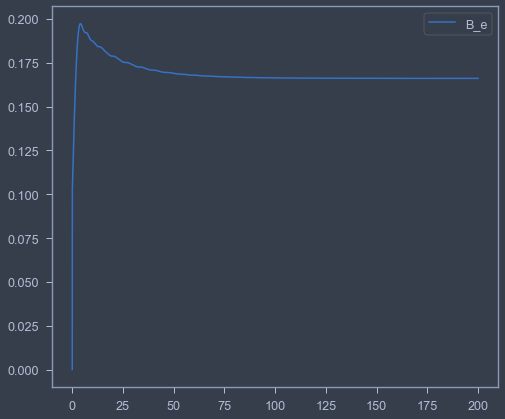

In [33]:
fig,ax=plt.subplots()
df_results.plot(y='B_e', ax=ax)

(0.16, 0.2)

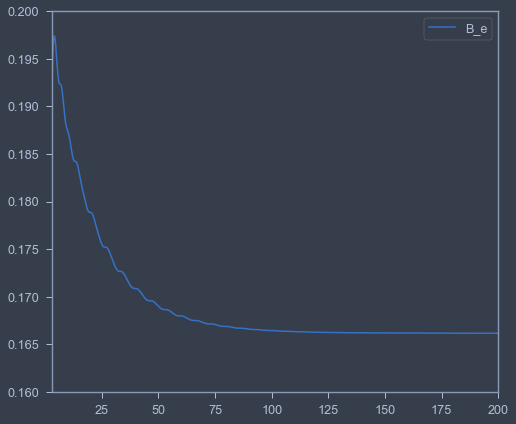

In [34]:
fig,ax=plt.subplots()
df_results.plot(y='B_e', ax=ax)
ax.set_xlim(3,200)
ax.set_ylim(0.16,0.20)

<a id='B_e'></a>

<AxesSubplot:xlabel='phi_a'>

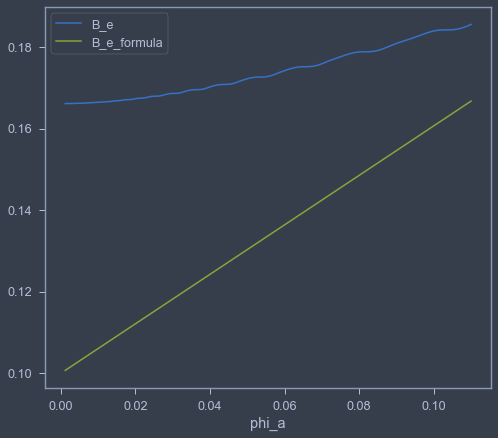

In [35]:
amplitudes = X_amplitudes['quadratic']
df_results['phi_a'] = np.interp(df_results.index,amplitudes.index,amplitudes['phi_a'])
omega0 = np.sqrt(C_1/A_44)
df_results['B_e_formula'] = B_1 + B_2*8/(3*np.pi)*omega0*df_results['phi_a']

fig,ax=plt.subplots()
mask = df_results['phi_a']<0.11
df_results.loc[mask].plot(x='phi_a', y=['B_e','B_e_formula'],ax=ax)

In [36]:
omega0 = np.sqrt(C_1/A_44)
df_results['zeta'] = df_results['B_e']/(2*omega0*A_44)

<AxesSubplot:xlabel='phi_a'>

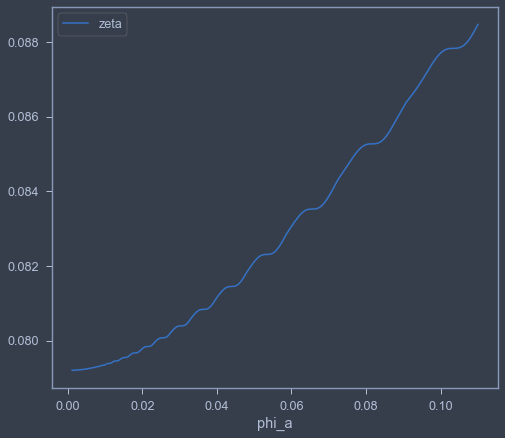

In [37]:
fig,ax=plt.subplots()
mask = df_results['phi_a']<0.11
df_results.loc[mask].plot(x='phi_a', y='zeta',ax=ax)

In [38]:
B_e = df_results['B_e'].iloc[-1]
B_e

0.16615505838874878

In [39]:
simulation = RollDecayLinear(A_44=A_44, B_1=B_e, C_1=C_1)
df_result = simulation.simulate(t=t, phi0=phi0, phi1d0=phi1d0)

<AxesSubplot:>

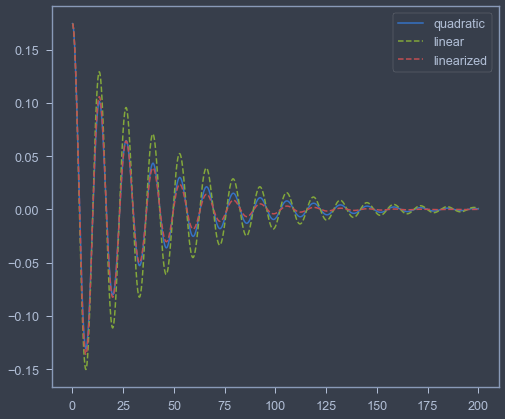

In [40]:
fig,ax=plt.subplots()
results['quadratic'].plot(y='phi', ax=ax, label='quadratic')
results['linear'].plot(y='phi', ax=ax, style='--', label='linear')
df_result.plot(y='phi', ax=ax, style='--', label='linearized')


<AxesSubplot:>

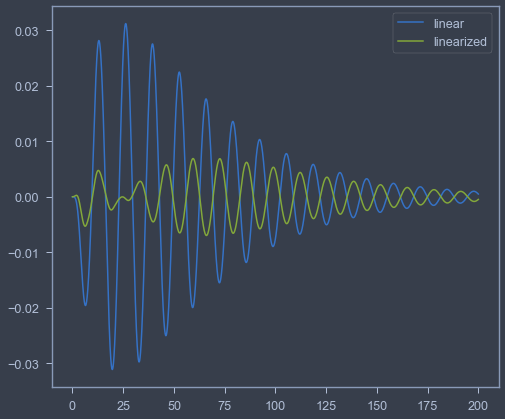

In [41]:
fig,ax=plt.subplots()


df_error = pd.DataFrame(index=df_result.index)
ref = results['quadratic']['phi']
df_error['linear'] = results['linear']['phi'] - ref
df_error['linearized'] = df_result['phi'] - ref

df_error.plot(ax=ax)

In [42]:
damping = equations.roll_decay_equation_himeno_quadratic_b.lhs.subs([(symbols.A_44,0),(symbols.C_1,0)])
Math(vlatex(damping))

<IPython.core.display.Math object>

In [43]:
x = sp.symbols('x')
damping2 = symbols.B_1*x + symbols.B_2*x**2
damping2

B_1*x + B_2*x**2

In [44]:
x = sp.symbols('x')
damping3 = symbols.B_1*x
damping3

B_1*x

In [45]:
s = sp.fourier_series(damping3, (x, -symbols.omega0/2*symbols.t, symbols.omega0/2*symbols.t))
s

FourierSeries(B_1*x, (x, -omega0*t/2, omega0*t/2), (0, SeqFormula(0, (_k, 1, oo)), SeqFormula(2*Piecewise((B_1*(-omega0**2*t**2*cos(_n*pi)/(4*_n*pi) + omega0**2*t**2*sin(_n*pi)/(4*_n**2*pi**2)) - B_1*(omega0**2*t**2*cos(_n*pi)/(4*_n*pi) - omega0**2*t**2*sin(_n*pi)/(4*_n**2*pi**2)), (_n > -oo) & (_n < oo) & Ne(_n, 0)), (0, True))*sin(2*_n*pi*x/(omega0*t))/(omega0*t), (_n, 1, oo))))

In [46]:
s_truncate = s.truncate(n=2)
s_truncate

B_1*omega0*t*sin(2*pi*x/(omega0*t))/pi - B_1*omega0*t*sin(4*pi*x/(omega0*t))/(2*pi)

In [47]:
sp.integrate(s_truncate,(symbols.t, -symbols.omega0/2*symbols.t, symbols.omega0/2*symbols.t))

-B_1*omega0*(-omega0**2*t**2*sin(4*pi*x/(omega0**2*t))/8 - pi*t*x*cos(4*pi*x/(omega0**2*t))/2 - 2*pi**2*x**2*Si(4*pi*x/(omega0**2*t))/omega0**2)/pi + B_1*omega0*(omega0**2*t**2*sin(4*pi*x/(omega0**2*t))/8 + pi*t*x*cos(4*pi*x/(omega0**2*t))/2 + 2*pi**2*x**2*Si(4*pi*x/(omega0**2*t))/omega0**2)/pi + B_1*omega0*(-omega0**2*t**2*sin(8*pi*x/(omega0**2*t))/8 - pi*t*x*cos(8*pi*x/(omega0**2*t)) - 8*pi**2*x**2*Si(8*pi*x/(omega0**2*t))/omega0**2)/(2*pi) - B_1*omega0*(omega0**2*t**2*sin(8*pi*x/(omega0**2*t))/8 + pi*t*x*cos(8*pi*x/(omega0**2*t)) + 8*pi**2*x**2*Si(8*pi*x/(omega0**2*t))/omega0**2)/(2*pi)

In [48]:
func = 2*x
s = sp.fourier_series(func, (x, -10, 10))
s

FourierSeries(2*x, (x, -10, 10), (0, SeqFormula(0, (_k, 1, oo)), SeqFormula(Piecewise((-400*cos(_n*pi)/(_n*pi) + 400*sin(_n*pi)/(_n**2*pi**2), (_n > -oo) & (_n < oo) & Ne(_n, 0)), (0, True))*sin(_n*pi*x/10)/10, (_n, 1, oo))))

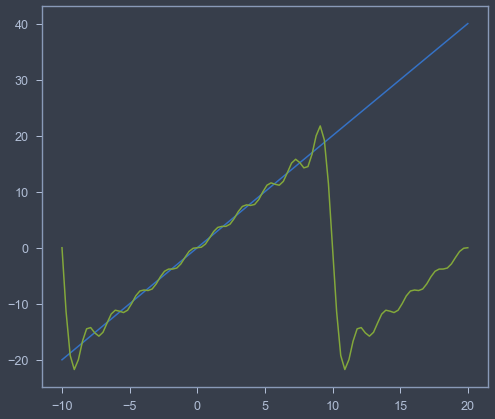

In [49]:
s_trunate = s.truncate(n=10)
s_lambda = lambdify(s_trunate)
func_lambda = lambdify(func)

x_ = np.linspace(-10,20,100)
y_ = s_lambda(x=x_)
y = func_lambda(x=x_)

fig,ax=plt.subplots()
ax.plot(x_,y, label='function')
ax.plot(x_,y_, label='fourier series n=1')

In [50]:
sp.integrate(x,(x, 0, 1))

1/2